### Dependencies

In [1]:
# !pip install fastai
!pip install fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.1 MB/s eta 0:00:00:00:010:01


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastbook import *
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

path.ls()

(path/'train').ls()


(#3) [Path('valid'),Path('labels.csv'),Path('train')]

(#2) [Path('train/7'),Path('train/3')]

In [4]:
## Loading images
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

img3_path = threes[2]
img3 = Image.open(img3_path)
img3

img7_path = sevens[2]
img7 = Image.open(img7_path)
img7

In [5]:
28*28

784

In [6]:
# Converting images to numpy array
arr3 = array(img3)
#Converting to pytorch tensor
ten3 = tensor(img3)
#Displaying them in a dataframe
three_df = pd.DataFrame(ten3)
three_df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1,18,93,164,254,255,254,254,254,151,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,13,36,151,253,253,253,253,253,253,218,239,213,10,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,89,253,253,253,245,172,82,82,82,2,148,253,150,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,89,253,252,171,54,0,0,0,0,37,177,253,188,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,17,151,51,0,0,0,0,0,40,229,253,253,147,0,0,0,0,0,0,0


In [7]:
# Calculating averages of all the pixels in each of the images
threes_tens = [tensor(Image.open(o)) for o in threes]
sevens_tens = [tensor(Image.open(o)) for o in sevens]

len(threes_tens)
len(sevens_tens)




6131

6265

<Axes: >

<Axes: >

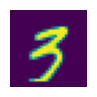

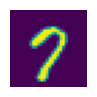

In [8]:
show_image(threes_tens[7])
show_image(sevens_tens[3])

In [9]:
### Converting 1d tensor to 3d tensor

stck_sevens = torch.stack(sevens_tens).float()/255
stck_threes = torch.stack(threes_tens).float()/255

# Length of a tensor shape is rank
len(stck_sevens.shape)

# dimenision and rank both are same
stck_sevens.ndim

3

3

<Axes: >

<Axes: >

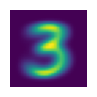

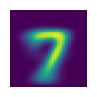

In [10]:
#Now taking average of all pixels which stacked together
mean_3 = stck_threes.mean(0)
show_image(mean_3)

mean_7 = stck_sevens.mean(0)
show_image(mean_7)

In [11]:
# Now the average is our ideal 3 lets calculate the difference mean abosule erro
# and root mean sq L2

l1_3 = (stck_threes[1] - mean_3).abs().mean()
l2_3 = ((stck_threes[1] - mean_3) **2).mean()

print(f'Error rate for threes : L1 : {l1_3}, L2 : {l2_3}')

l1_7 = (stck_sevens[1] - mean_7).abs().mean()
l2_7 = ((stck_sevens[1] - mean_7) **2).mean()

print(f'Error rate for sevens : L1 : {l1_7}, L2 : {l2_7}')

Error rate for threes : L1 : 0.11143654584884644, L2 : 0.040837619453668594
Error rate for sevens : L1 : 0.13037648797035217, L2 : 0.06681827455759048


In [12]:
# Calculating loss using default function - Pytorch Here F uses torch.nn.functional
F.l1_loss(stck_threes[1],mean_3)
F.mse_loss(stck_threes[1],mean_3)

tensor(0.1114)

tensor(0.0408)

### Some theory on arrays and tensors

In [13]:

a = [[1,3,4],
     [6,8,2]]

a_arr = array(a)
a_tns = tensor(a)

print(a_arr)
print(a_tns)

[[1 3 4]
 [6 8 2]]
tensor([[1, 3, 4],
        [6, 8, 2]])


In [14]:
a_tns[0,0]

a_tns[0:,1]

a_tns + 1

a_tns.type()

a_tns * 1.5

tensor(1)

tensor([3, 8])

tensor([[2, 4, 5],
        [7, 9, 3]])

'torch.LongTensor'

tensor([[ 1.5000,  4.5000,  6.0000],
        [ 9.0000, 12.0000,  3.0000]])

### Validation Set

In [15]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()])

# Preprocessing
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape
valid_7_tens.shape

valid_3_tens.ndim

torch.Size([1010, 28, 28])

torch.Size([1028, 28, 28])

3

In [16]:
def mnist_distance(valid_tens,true_tens):
    return (valid_tens - true_tens).abs().mean((-1,-2))

# Even though shapes are different it is able to calculate subraction 
#because of the tensor shape 
valid_3_dist = mnist_distance(valid_3_tens,mean_3)
valid_7_dist = mnist_distance(valid_7_tens,mean_7)

In [17]:
valid_3_dist.shape
valid_7_dist.shape

torch.Size([1010])

torch.Size([1028])

In below code even though A and B are in different shapes, pytoch broadcasts the smaller tensor b to the shape of a and adds it

In [18]:
# Some things about broadcasting
a = tensor([1,3,4]) 
b = tensor([2])
a + b



tensor([3, 5, 6])

Now going bac to our example of is 3 or 7

In [19]:
def is_3(x):
    return mnist_distance(x,mean_3) < mnist_distance(x,mean_7)

is_3(valid_7_tens[1])
is_3(valid_3_tens[5])

# NOw using broadcasting we will calculate for all validation set and calculate accuracy

accuracy_3 = is_3(valid_3_tens).float().mean()
accuracy_7 = (1 - is_3(valid_7_tens).float().mean())

print(f'Accuracy of 3 :{accuracy_3}')
print(f'Accuracy of 7 :{accuracy_7}')

tensor(False)

tensor(True)

Accuracy of 3 :0.9168316721916199
Accuracy of 7 :0.9854085445404053


### Calculating Gradients

In [20]:
def f(x):
    return x**2

# plot_function(f,'x','x^2')
# plt.scatter(-1.5,f(-1.5), color = 'green')

# Calculating gradient using pytorc

# Defining at what value you want the grad
xt = tensor(3.).requires_grad_()

# Passing the value to loss function
yt = f(xt)

yt

# Calculates gradient of loss function
yt.backward()

# Gradient value of the function - (3^2 --> 9 --> yt.backward() 
#(x^2 becomes 2x) --> so xt.grad becomes 3*2 = 6
xt.grad

tensor(9., grad_fn=<PowBackward0>)

tensor(6.)

In [21]:
#One more example

xt = tensor([2.,4.,5.]).requires_grad_()

def f(x): return(x**2).sum()

yt = f(xt)
yt
yt.backward() #(x**2 becomes 2x for each value in the tensor)
xt.grad

tensor(45., grad_fn=<SumBackward0>)

tensor([ 4.,  8., 10.])

### End to End SGD example

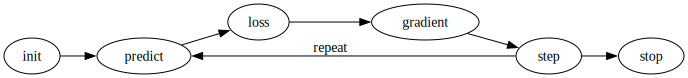

In [22]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

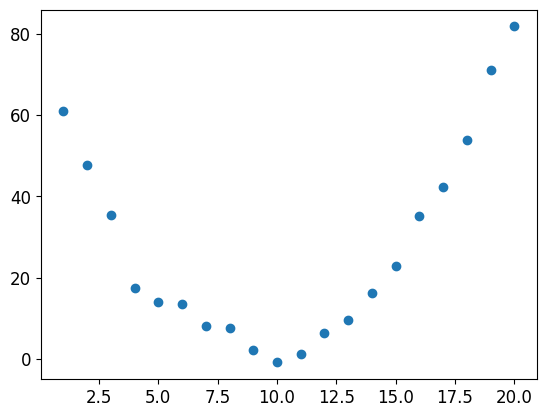

In [23]:
# Measuuring the speed of a roller coaster

# Lets create a time variale for 20 seconds
time = torch.arange(1,21).float()
time

#Lets create a speed variable

speed = torch.randn(20) * 3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time, speed)

Orginal Weights:tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)
Predictions:tensor([-1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02, -1.5926e+02,
        -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02, -3.2000e+02], grad_fn=<AddBackward0>)
loss:33737.1953125
parameter gradient:tensor([-69349.5156,  -4228.3770,   -287.5256])
Updated Weights:tensor([-0.0723, -0.7083,  1.3554])


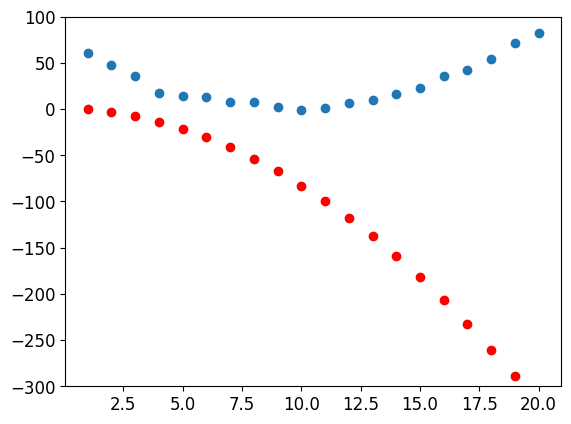

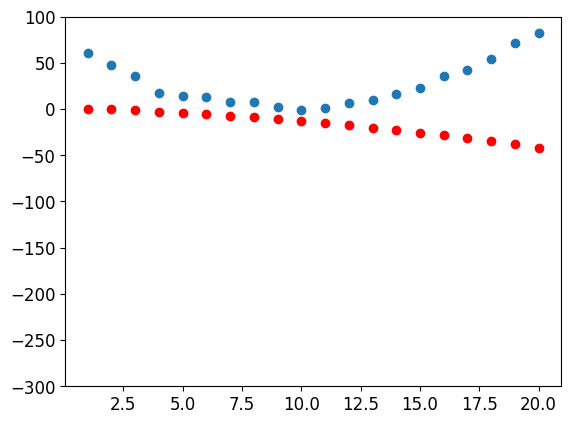

In [24]:
# Activation function
def f(t,params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

#Loss function
def mse(actuals, preds):
    return ((preds-actuals)**2).mean()

# Initializing weights
params = torch.randn(3).requires_grad_()
print(f'Orginal Weights:{params}')

#Saving inital weights
orig_params = params.clone()

#Calculate predicitions
predictions = f(time,params)
print(f'Predictions:{predictions}')

# Lets visualize predicitions
def show_preds(preds, ax = None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time,to_np(preds), color = 'red')
    ax.set_ylim(-300, 100)
    return

show_preds(predictions) # Going in negative direction

# Calculating loss
loss = mse(speed, predictions)
print(f'loss:{loss}')

#Calculate Gradients
loss.backward()
print(f'parameter gradient:{params.grad}')


#Now Optimize weights or parametersbased on the loss
lr = 1e-5 # Learning rate

params.data -= params.grad * lr
params.grad = None

print(f'Updated Weights:{params.data}')

#See if predictions improved
predictions = f(time,params)
show_preds(predictions) 

Loss:2971.96728515625
Loss:651.590576171875
Loss:1522.4622802734375
Loss:3515.979736328125
Loss:1896.895751953125
Loss:511.03216552734375
Loss:2650.2333984375
Loss:3233.196533203125
Loss:875.1726684570312
Loss:1177.183349609375


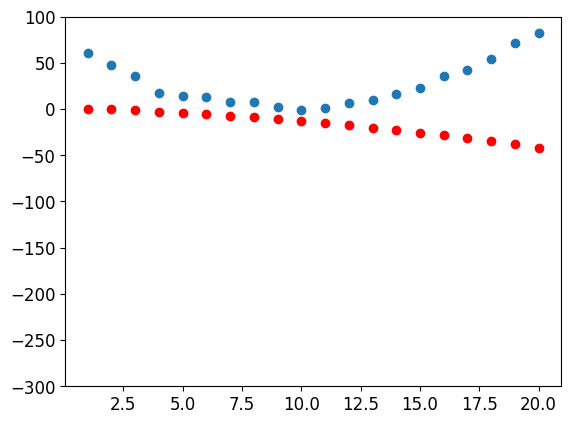

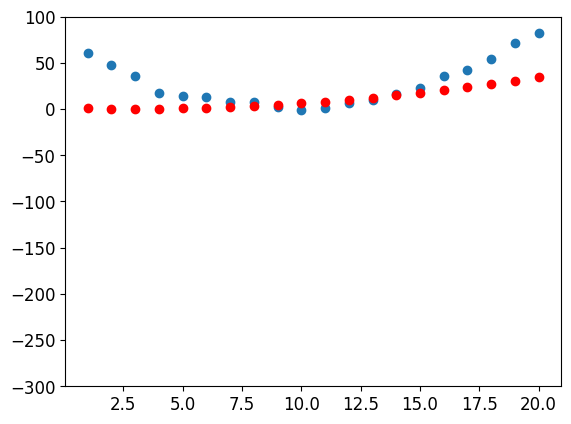

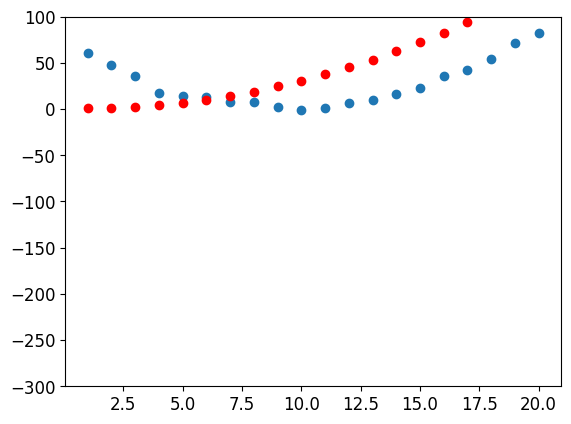

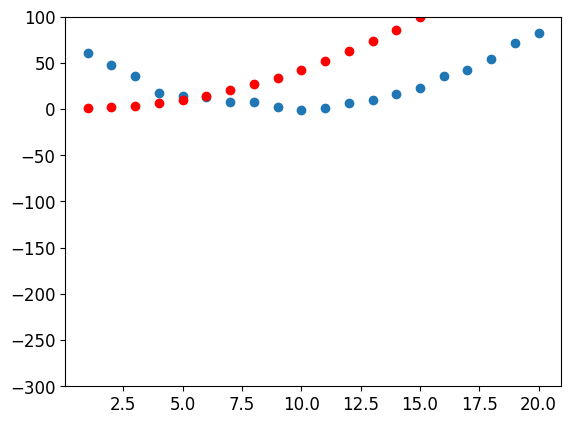

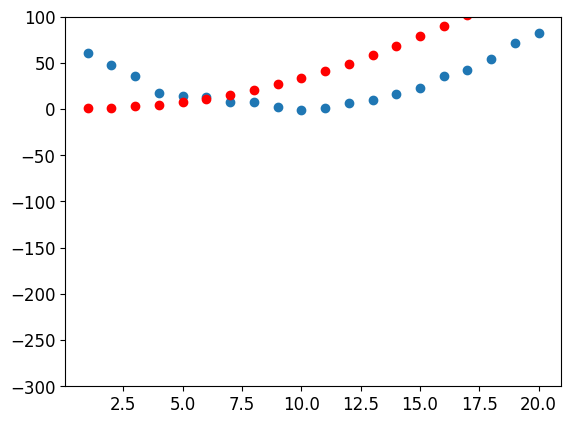

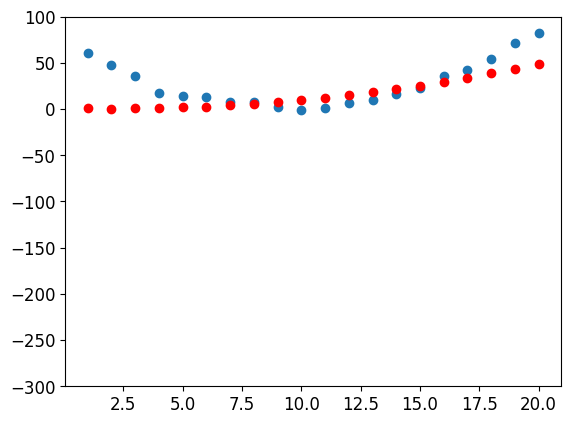

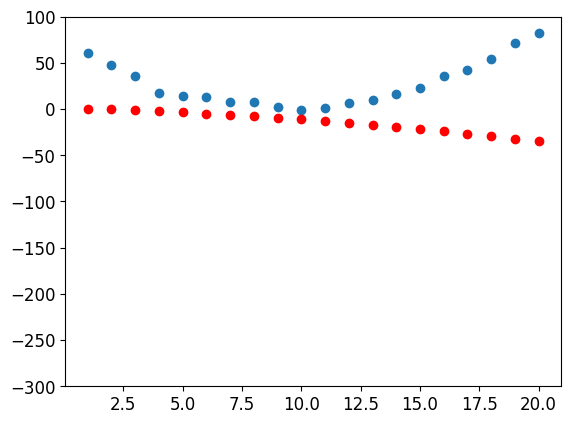

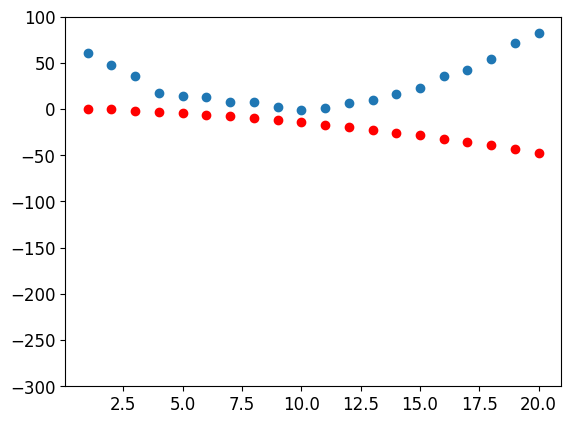

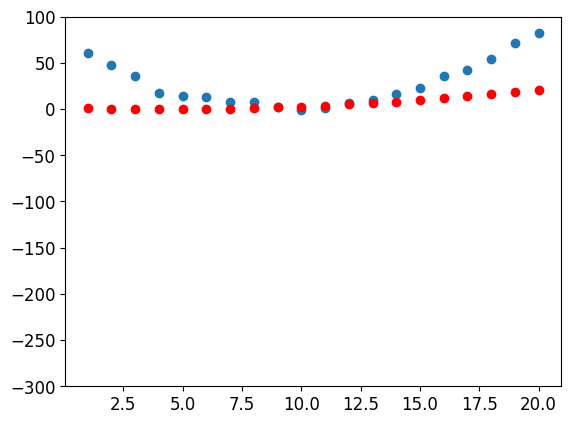

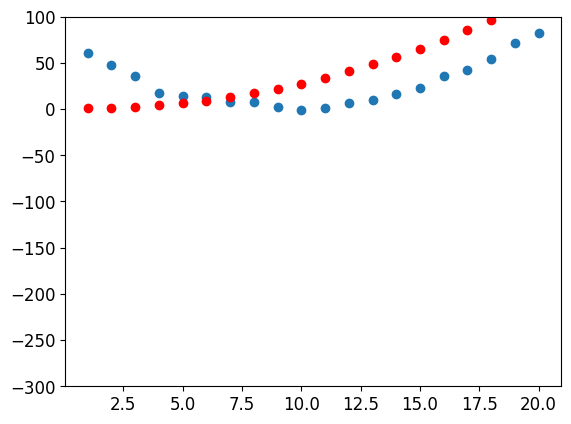

In [25]:
lr = 1e-5 # Learning Rate
def apply_step(params, prnt = True):
    preds = f(time,params)
    show_preds(preds)
    loss = mse(speed,preds)
    loss.backward()
    params.data -= params.grad * lr
    if prnt : print(f'Loss:{loss.item()}')
    return 

for i in range(10): apply_step(params) # 10 epochs

In [26]:
print(orig_params) # Orginal Parameter
print(params) # Final parameters after 10 epochs

# params = orig_params.detach().requires_grad_()
# params

tensor([-0.7658, -0.7506,  1.3525], grad_fn=<CloneBackward0>)
tensor([ 0.4755, -0.6775,  1.3641], requires_grad=True)


## What does unsqueeze does?

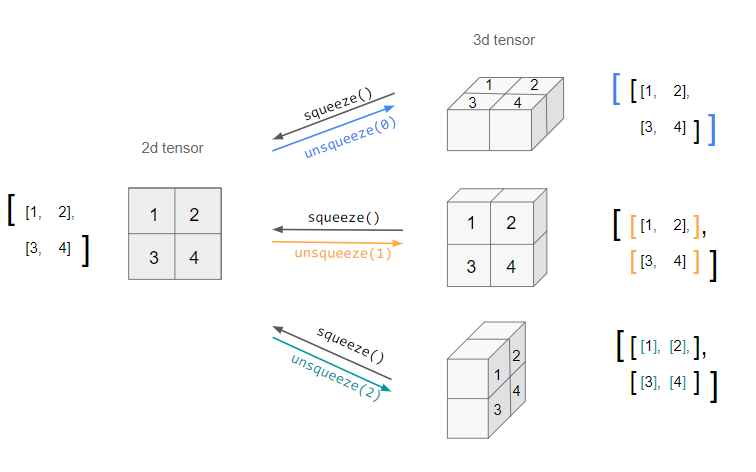

### Applying the same logic to MNIST

In [27]:
# Creation of independent variables - train x
stck_threes.shape
stck_sevens.shape
train_x = torch.cat([stck_threes,stck_sevens]).view(-1,28*28)
train_x.shape

#Creation of dependent variables - train y
train_y = tensor([1]*len(threes) + [0] * len(sevens)).unsqueeze(1)
train_y.shape


# Creation of dataset - training
train_ds  = list(zip(train_x,train_y))
x,y = train_ds[0]
x.shape, y

# Creation of dataset - testing
valid_x = torch.cat([valid_3_tens,valid_7_tens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3_tens)+[0]*len(valid_7_tens)).unsqueeze(1)

#Creation of dataset - validation 
valid_ds = list(zip(valid_x,valid_y))

# Step 1   - Initializing weights

def init_params(size,std=1.0):
    params = (torch.randn(size)*std).requires_grad_()
    return params


weights = init_params((28*28,1))

bias = init_params(1)

bias.shape
weights.shape 




torch.Size([6131, 28, 28])

torch.Size([6265, 28, 28])

torch.Size([12396, 784])

torch.Size([12396, 1])

(torch.Size([784]), tensor([1]))

torch.Size([1])

torch.Size([784, 1])

In [28]:
# For one imahge
(train_x[0]* weights.T).sum() + bias


# Using matrix multpilcation to calculate output for all inputs
def linear1(xb):
    return xb@weights + bias # here @ is the matrix multiplication

#getting bredicitons
preds = linear1(train_x)
preds

#Calculating accuracy
corrects  = (preds>0.0).float() == train_y
accuracy = corrects.float().mean().item()

accuracy


tensor([20.2336], grad_fn=<AddBackward0>)

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

0.4912068545818329

Unfortunately, we have a significant technical problem here. The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: (y_new - y_old) / (x_new - x_old). This gives us a good approximation of the gradient when x_new is very similar to x_old, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from x_old to x_new isn't likely to cause any prediction to change, so (y_new - y_old) will almost always be 0. In other words, the gradient is 0 almost everywhere.

In [29]:
# Changing the weights to see the change accuracy
with torch.no_grad(): 
    weights[0] *= tensor([1.001])

def linear1(xb):
    return xb@weights + bias     
#getting bredicitons
preds = linear1(train_x)
preds
#Calculating accuracy
corrects  = (preds>0.0).float() == train_y
accuracy = corrects.float().mean().item()
accuracy

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

0.4912068545818329

we can't use accuracy as loss function because it will be a constant number, taking gradient of constant number will be always zero, and only on the threshold point the gradient will be infinite

In [30]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1- predictions, predictions).mean()

# Lets test an example
act= tensor([1,0,1])
pred = tensor([0.9,0.4,0.2])

mnist_loss(pred, act) 


tensor(0.4333)

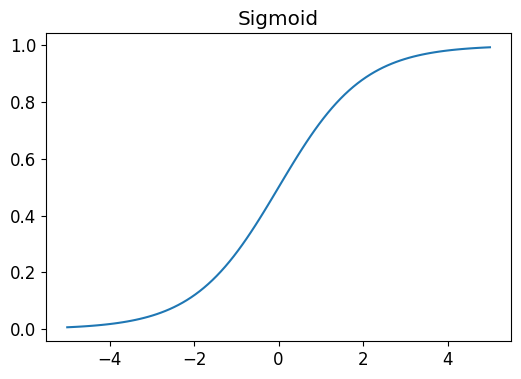

In [31]:
# Here the mnist loss functions assumes that predictions will be always between 0 and 1
# so we have to make sure the activation function outputs only results between 0 and 1
def sigmoid(x):
    return 1/(1+torch.exp(-x))


plot_function(torch.sigmoid, title = 'Sigmoid', min = -5, max = 5)


#Now lets update the mnist loss functions to update the outputs to be within 0 and 1

def mnist_loss(predictions, actuals):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1- predictions, predictions).mean()



### Putting it all together - SGD & MNIST

In [32]:
def init_params(size,std=1.0):
    params = (torch.randn(size)*std).requires_grad_()
    return params


def linear1(xb):
    return xb@weights + bias # here @ is the matrix multiplication

def mnist_loss(predictions, actuals):
    predictions = predictions.sigmoid()
    return torch.where(actuals == 1, 1- predictions, predictions).mean()

def calc_grad(batch_data,target_vals,model):
    preds = model(batch_data)
    loss = mnist_loss(preds,target_vals)
    loss.backward()
    return preds
    
def train_epoch(model,lr,params):
    for batch_x, batch_y in train_dl:
        preds = calc_grad(batch_x,batch_y, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()


def calc_batch_accuracy(preds,target_vals):
    predictions = torch.sigmoid(preds)
    correct_preds = ((preds>0.5) == target_vals).float()
    return correct_preds.mean()

def calc_validate_epoch(model):
    valid_accs = [calc_batch_accuracy(model(xb),yb) for xb,yb in valid_dl]
    return round(torch.stack(valid_accs).mean().item(), 5)




    
# Initializing weights & Bias
weights = init_params((28*28),1)
bias = init_params(1)
params = weights, bias


#Data Preparation - train set
train_dl = DataLoader(train_ds, batch_size = 256)


#Data Preparation - test set
valid_dl = DataLoader(valid_ds, batch_size = 256)
first(valid_dl)[0].shape,first(valid_dl)[1].shape




# Setting learning rate and no of epochs
train_log_df = pd.DataFrame()
lr = 0.1
epochs = 20
#Model training
for i in range(epochs):
    train_epoch(linear1,lr,params)
    predictions = linear1(train_x)
    train_accuracy = calc_batch_accuracy(predictions,train_y.squeeze(1)).item()
    valid_accuracy  = calc_validate_epoch(linear1)
    temp_df = pd.DataFrame({f'Epoch': i, 'Train Accuracy':train_accuracy,'valid_accuracy':valid_accuracy}, index = np.arange(1))
    train_log_df = pd.concat([train_log_df,temp_df],ignore_index = True)
    
train_log_df    







#


(torch.Size([256, 784]), torch.Size([256, 1]))

,Epoch,Train Accuracy,valid_accuracy
0,0,0.501371,0.51362
1,1,0.517748,0.52337
2,2,0.531704,0.53717
3,3,0.548725,0.55673
4,4,0.578170,0.58604
5,5,0.634640,0.64175
6,6,0.705954,0.71317
7,7,0.773717,0.78324
8,8,0.822039,0.83264
9,9,0.852130,0.86314


### Optimizer

In [33]:
#Understanding *args & **kwards
def myFun(*args, **kwargs):
    print("args: ", args)
    print("kwargs: ", kwargs)


# Now we can use both *args ,**kwargs
# to pass arguments to this function :
myFun('geeks', 'for', 'geeks', first="Geeks", mid="for", last="Geeks")

args:  ('geeks', 'for', 'geeks')
kwargs:  {'first': 'Geeks', 'mid': 'for', 'last': 'Geeks'}


In [34]:
# Now lets use pytorch to use fasten the process

# Setting model architecture, weights & bias
linear_model = nn.Linear(28*28,1)
w,b = linear_model.parameters()

w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [35]:
class BasicOptimizer:
    def __init__(self,params,lr):
        self.params = list(params)
        self.lr = lr
    
    def step(self,*args,**kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr
            p.grad_ = None
    def zero_grad(self,*args,**kwargs):
        for p in self.params : p.grad = None
            

def train_one_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

def train_model(model,epochs):
    for i in range(epochs):
        train_one_epoch(model)
        print(calc_validate_epoch(model),end = ' ')

lr = 0.01
opt = BasicOptimizer(linear_model.parameters(),lr)

train_model(linear_model,20)


0.64746 0.82422 0.89551 0.92527 0.94041 0.94627 0.94871 0.95311 0.9575 0.96043 0.96141 0.96139 0.96187 0.96139 0.96187 0.96236 0.96236 0.96236 0.96236 0.96236 

In [39]:
def train_one_epoch(model):
    for xb,yb in train_dl:
        calc_grad(xb,yb,model)
        opt.step()
        opt.zero_grad()

def train_model(model,epochs):
    for i in range(epochs):
        train_one_epoch(model)
        print(calc_validate_epoch(model),end = ' ')
        
# Now we will replace our Basic optimizer with SGD which is there in FAST AI
lin_mod= nn.Linear(28*28,1)
opt = SGD(lin_mod.parameters,0.1)

train_model(lin_mod,20)




0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 0.50928 

In [41]:
#Now using high level API like fast ai to do the process

dls = DataLoaders(train_dl,valid_dl)
mnist_learner = Learner(dls, nn.Linear(28*28,1),opt_func= SGD,
                       loss_func = mnist_loss,metrics = calc_batch_accuracy )

mnist_learner.fit(15,lr = 0.01)

epoch,train_loss,valid_loss,calc_batch_accuracy,time
0,0.429151,0.350353,0.716389,00:00
1,0.319836,0.263555,0.824828,00:00
2,0.246747,0.205949,0.896958,00:00
3,0.198511,0.169435,0.922473,00:00
4,0.166255,0.146036,0.940137,00:00
5,0.144234,0.130101,0.948479,00:00
6,0.128704,0.118585,0.951914,00:00
7,0.117321,0.109856,0.955839,00:00
8,0.108652,0.102987,0.957802,00:00
9,0.101818,0.097422,0.957802,00:00


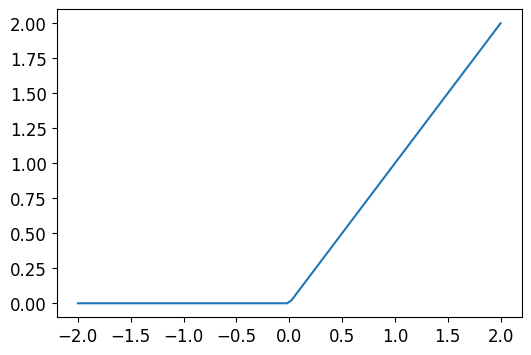

In [42]:
# Adding non linearity between networks
plot_function(F.relu)

In [43]:
## Replacing linear model(one layer) with neural networks
# ita just the same linearnetworks u add non linearity in between

def simple_net(xb):
    res1 = xb@w1 + b1
    res1 = res1.max(tensor(0.0))
    res = res1@w2 + b2
    return res

w1 = init_params((28*28,30))
b1 = init_params(30)

w2 = init_params((30,1))
b2 = init_params(1)




In [46]:
# Same implementation in Pytorch

simple_net = nn.Sequential(
                nn.Linear(28*28,30),
                nn.ReLU(),
                nn.Linear(30,1) 
)

learn = Learner(dls,simple_net, opt_func = SGD,
               loss_func = mnist_loss, metrics = calc_batch_accuracy)


learn.fit(30,0.1)

epoch,train_loss,valid_loss,calc_batch_accuracy,time
0,0.296038,0.407808,0.504416,00:00
1,0.138809,0.221001,0.762022,00:00
2,0.077651,0.112858,0.896958,00:00
3,0.051642,0.076918,0.929343,00:00
4,0.039547,0.060362,0.947007,00:00
5,0.033327,0.051007,0.958292,00:00
6,0.029719,0.045073,0.963690,00:00
7,0.027353,0.040994,0.967125,00:00
8,0.025634,0.038011,0.967615,00:00
9,0.024296,0.035729,0.969087,00:00


Final Accuracy: 0.9798822402954102


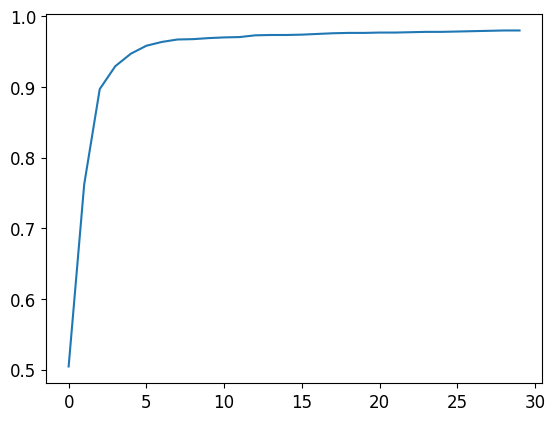

In [50]:
plt.plot(L(learn.recorder.values).itemgot(2))
print(f'Final Accuracy: {learn.recorder.values[-1][2]}')